In [1]:
import zipfile
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

if not os.path.exists('data_labels_extraData.csv'):
    with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
    print('Data extracted successfully')
else:
    print('Data previously extracted')

main_data = pd.read_csv('./data_labels_mainData.csv')
extra_data = pd.read_csv('./data_labels_extraData.csv')
print("Main data : {}, Extra Data: {}".format(main_data.shape, extra_data.shape))

Data previously extracted
Main data : (9896, 6), Extra Data: (10384, 4)


In [2]:
# As there is an isCancerous column for both datasets
# We will join them for this model
data = pd.concat([extra_data, main_data], axis=0, ignore_index=True) # concatenating along rows
data = data.drop(columns=['cellTypeName', 'cellType']) # Drop unnecessary columns
# Split into train, test and val
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape, val_data.shape, test_data.shape))
display(train_data)

Train data : (12168, 4), Val Data: (4056, 4), Test Data: (4056, 4)


,InstanceID,patientID,ImageName,isCancerous
233,18792,63,18792.png,0
17678,3280,46,3280.png,1
2371,6956,71,6956.png,0
5032,2919,80,2919.png,1
9768,21702,92,21702.png,0
...,...,...,...,...
18424,3378,51,3378.png,0
1897,6656,69,6656.png,0
3995,10620,79,10620.png,0
6833,9608,86,9608.png,0


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

train_datagen = ImageDataGenerator(data_format='channels_last')
val_datagen = ImageDataGenerator(data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,  
        class_mode='binary')



Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization
)

# Define input shape based on 27x27 RGB images
input_shape = (27, 27, 3)

# Build a simple base CNN model
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Dropout(0.25),

    # Flatten and dense layers
    Flatten(),
    Dense(128, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.5),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.metrics.AUC(name='auc')]
)

# Display model summary
model.summary()


C:\Users\rohan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 27, 27, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,561 (1.20 MB)

 Trainable params: 314,561 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
epochs = 50
history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs)

Epoch 1/50


C:\Users\rohan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


381/381 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.6810 - auc: 0.6923 - loss: 5.4764 - val_accuracy: 0.8190 - val_auc: 0.8904 - val_loss: 0.4011
Epoch 2/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8095 - auc: 0.8823 - loss: 0.4109 - val_accuracy: 0.8208 - val_auc: 0.8924 - val_loss: 0.4009
Epoch 3/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8312 - auc: 0.9010 - loss: 0.3789 - val_accuracy: 0.8516 - val_auc: 0.9198 - val_loss: 0.3523
Epoch 4/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8460 - auc: 0.9174 - loss: 0.3476 - val_accuracy: 0.8501 - val_auc: 0.9257 - val_loss: 0.3596
Epoch 5/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8525 - auc: 0.9210 - loss: 0.3405 - val_accuracy: 0.8383 - val_auc: 0.9173 - val_loss: 0.3735
Epoch 6/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8663 - auc: 0.9346 - loss: 0.3093 - val_accuracy: 0.8659 - val_auc: 0.9268 - val_loss: 0.3253
Epoch 7/50
381/381 ━━━━━━━━━━━━━━━━━━━━

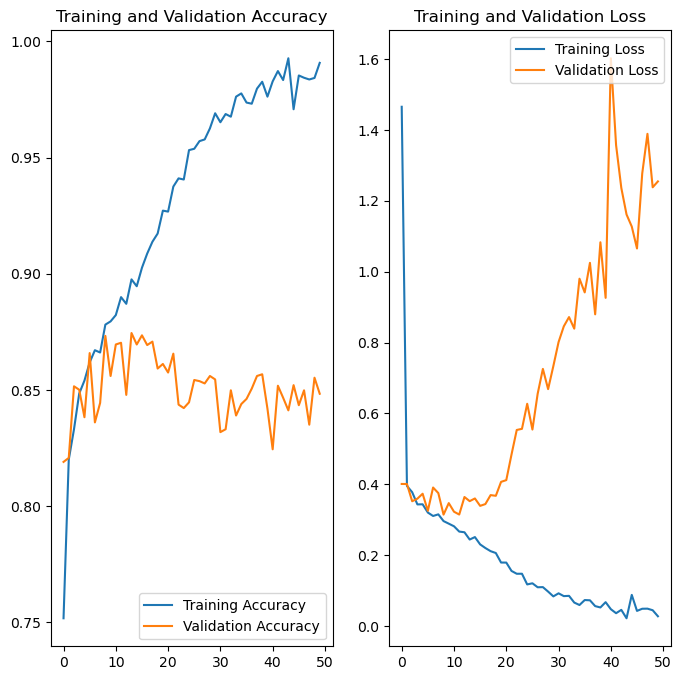

In [6]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()